# Project 2

## Base Information

Our PDF has a form: $$P\left(t ; V, \tau, \Delta m_{s}\right) \propto(1+V \sin (\Delta m t)) \times \exp (-t / \tau)$$
with:
 - t is the observable quantity - the decay time of each decay
 - $\tau$ is a lifetime parameter
 - V is a parameter which measures matter/anti-matter asymmetry and has the value zero if
the universe is symmetric (which we know it isnt !)
 - ∆m is a mass difference parameter which leads to sinusoidal oscillations superimposed on
the exponential decay


Values of our Parameters:
 - $\tau$ = 1.5
 - V = 0.1
 - ∆m = 20.0

## Imports

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from iminuit import Minuit
import matplotlib.pyplot as plt
from scipy.integrate import quad

## Main PDF Class

In [2]:
#Class for out pdf with required methods, we have parameters = lifetime, asymm and mass difference

class PDF:
    def __init__(self, params, limits, analytic = True):
        self.data = []
        self.limits = limits    
        self.setParams(params)
        self.fmax = self.evaluate(limits[0]) + 0.5 #Since decaying func, max in a range is always first value
        self.integrator = self.setIntegrator(analytic) # Calls the setting function for integration
        
    #Allows us to switch for the quad integration(slow) to analytical(faster) using an argument
    def setIntegrator(self, analytic):
        if analytic == False:
            return self.QuadIntegrator
        else:
            return self.AnalyticIntegrator
        
    def setParams(self, params):
        self.tau = params[0]
        self.v = params[1]
        self.m = params[2]
        
    #Integrtaes our evaluation function with the scipy.quad module
    def QuadIntegrator(self):
        integral = quad(self.evaluate, self.limits[0], self.limits[1])[0]
        return integral
    
    #Integrates out evaluation function using the analytic solution to the integral with limits 0 and infinity
    def AnalyticIntegrator(self):
        part1 = self.tau + ((self.m*self.v)/(self.m**2 + 1/(self.tau**2)))
        return part1
    
    #Random box to generate data of the PDF
    def next(self):
        while True:
            x1 = np.random.uniform(0,1)
            x1 = self.limits[0] + (self.limits[1]-self.limits[0])*x1
            y1 = self.evaluate(x1)
            y2 = np.random.uniform(0,1)
            y2 = self.fmax*y2
            if(y2<y1):
                self.data.append(x1)
                return x1
            
    #Evaluation function for passed data
    def evaluate(self, x):
        value = ( 1 + self.v* math.sin( x*self.m) ) * ( math.exp( -x / self.tau ) )
        return value
    
    #Normalised evaluation function for passed data
    def evalNorm(self, x):
        value = self.evaluate(x)
        integral = self.integrator()
        return value/integral
    

## Negative Log Likelihood Class

In [3]:
#Objective function class for minimisation
class NLL():
    def __init__(self, data, function):
        self.data = data
        self.function = function
    
    def setParams(self, params):
        self.function.setParams(params)
        
    def evaluate(self):
        nll = 0.0
        for i in range(len(self.data)):
            prob = self.function.evalNorm(self.data[i])
            if prob<0: prob = 0.00000000001
            self.prob = prob
            logP = math.log(prob)
            nll += logP
        return -nll

## Plotting Function
 - Generailsed plotting function
 - Takes set limits, a pdf class if available
 - If no pdf, the function just plots the data in a standard histogram
 - If a pdf class is provided, the data is plotted with a fit overlay determined by the most recently stored param values in the class.

In [4]:
def plotting(data, pdf = None, bins = 100, limits = [0, 10]):
    if pdf == None:
        plt.hist(data, bins, range = limits, density = True)
        plt.xlabel('Decay Time')
        plt.ylabel('Counts')
        plt.title('Generated Data')
        plt.show()
        
    else:
        y = []
        x = np.linspace(limits[0], limits[1], bins)
        #Finds y values of pdf equation using equally seperated x points
        for i in x:
            y.append(pdf.evalNorm(i))
        plt.plot(x, y)
        #Plots a normalised histogram
        plt.hist(data, bins, range = limits, density = True)
        plt.xlabel('Decay Time')
        plt.ylabel('Counts')
        plt.title('Fit Overlay on Data')
        plt.show()


## Data Generation
 - Generates data using a provided pdf
 - The pdf provided must be given a list of suitable parameters, these are predefined as they are the same all way thorughout, however can be changed if needed/passed in as a new argument
 - The limits for this pdf in theory should be between 0 and infinity, using infinity isnt reasonable here. A very high value means that on average we are not going to find values that represnt the pdf. That is why the limit here is set to 200. It represents a value where the exp portion of the pdf essentially drives the function to 0 however also not too large that few data points created are part of the pdf.
 - Takes n as an argument for number of datapoints wanted in the dataset

In [5]:
def dataGen(n, pdf_of_choice, params = [1.5, 0.1, 20.0], limits = [0, 200], plot = False):
    pdf = pdf_of_choice(params, limits)
    data = []
    for i in range(n):
        data.append(pdf.next())
    #By default doesnt plot the generated data but can if wanted
    if plot == True:
        #pdf isnt given so will only plot the data and not a fit
        plotting(data)
    return data

## Fitting Functions

In [6]:
#Our objective function for minuit
def evalPDF(tau, v, m):
    nll.setParams([tau, v, m])
    result = nll.evaluate()
    return result

#Generalised fitting function. Has similar arguments for as pregious discussed functions
def fit(pdf_class, data, dictParams, listParams, objFunc, limits = [0,200], plot = True, analytic = True):
    global nll
    pdf = pdf_class(listParams, limits, analytic)
    nll = NLL(data, pdf)
    
    minObj = Minuit(objFunc, **dictParams, errordef = 1.)
    
    result = minObj.migrad()
    outParams = minObj.values
    fitErrors = minObj.errors
    
    #by default plots the fit data with the minimised params
    if plot == True:
        plotting(data, pdf)
    #returns the fit params and errors
    return outParams, fitErrors

## Part 1
 - Measure expected statistical precision for the parameters with i)10,000 and ii)100,000 data point.
 - All the params/ errors and data are stored for later use in comparitive fitting etc 
 - In a for loop:
     - Create data of size i for out main pdf
     - fits the data with some initial params
     - Prints the results with their relevant statistical uncertainties
 - The initial params given to both fitting procedures is the same

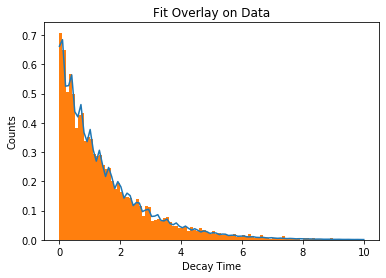

Param Values for 10000 datapoints::
Tau: 1.505 +/- 0.021
V: 0.116 +/- 0.020
Delta M: 20.008 +/- 0.078




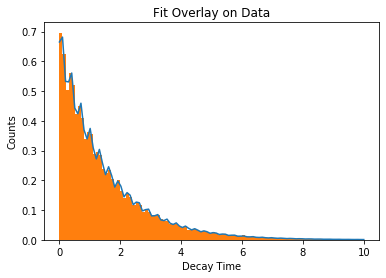

Param Values for 100000 datapoints::
Tau: 1.499 +/- 0.007
V: 0.106 +/- 0.006
Delta M: 20.009 +/- 0.028




In [7]:
allParams = []
allErrors = []
allData = []
for i in [10000, 100000]:
    data = dataGen(i, PDF)
    minParams = {'tau':1.5, 'v':0.1, 'm':20.0, 'error_tau':0.1, 'error_v':0.1, 'error_m':0.1}
    listParams = [1.5, 0.1, 20.0]
    
    outParams, outErrors = fit(PDF, data, minParams, listParams, evalPDF)
    allData.append(data)
    allParams.append(outParams)
    allErrors.append(outErrors)
    
    print('Param Values for {} datapoints::'.format(i))
    print('Tau: {:.3f} +/- {:.3f}'.format(outParams[0], outErrors[0]))
    print('V: {:.3f} +/- {:.3f}'.format(outParams[1], outErrors[1]))
    print('Delta M: {:.3f} +/- {:.3f}'.format(outParams[2], outErrors[2]))
    print('\n')

### Discussion
 - For 10,000 Data Points we see that the fit parameters have fairly large uncertiaanities associated with them. This can be seen from the fact that the original 'real' values are only approximately a third $\sigma$ from the fit parameters.
 - The 100,000 point data fitting returens much smaller parameter uncertainties, making each parameter within either one or two $\sigma$ from the real values.
 - Takeaway: Using a larger number of datapoints reduces the statistical uncertainty associated with each of the fit parameters.

## Part 2

### New PDFs for Data Creation
 - Here we create two new classes which inherit from our main PDF
 - These classes each draw their lifetime from gaussians with mean tau and width tau x 0.01 or width tau x 0.03
 - All functions other than evaluate do not have to be changed since we are only generating data and not fitting with these new pdfs.

In [8]:
#New classes inherit from the main PDF class with redefined evaliate functions for data generation
class biasedPDF_1(PDF):
    def evaluate(self, x):
        self.f = 0.01
        tau = np.random.normal(self.tau, self.tau * self.f)
        value = ( 1 + self.v* math.sin( x*self.m) ) * ( math.exp( -x / tau ) )
        return value
    
class biasedPDF_2(PDF):
    def evaluate(self, x):
        self.f = 0.03
        tau = np.random.normal(self.tau, self.tau * self.f)
        value = ( 1 + self.v* math.sin( x*self.m) ) * ( math.exp( -x / tau ) )
        return value

### Calculating Biases
 - We define bias as the shift seen in fit parameters between our original pdf and our new pdfs with a gaussian sampled tau
 - The error on the bias is the error on both of the pdfs paramaters combined in quadrature as the operation is subtraction(difference)

In [9]:
#First extract original stored params form part 1 as well as their respective errors
regParams = allParams[0]
regErrors = allErrors[0]

#loops over both of the f values 
for i in [0.01, 0.03]:
    #Uses the i to pick which pdf to generate data for
    if i == 0.01:
        biasedData = dataGen(10000, biasedPDF_1)
    else:
        biasedData = dataGen(10000, biasedPDF_2)
    
    #Fit with the same initial params 
    minParams = {'tau':1.5, 'v':0.1, 'm':20.0, 'error_tau':0.1, 'error_v':0.1, 'error_m':0.1}
    listParams = [1.5, 0.1, 20.0]
    newParams, newErrors = fit(PDF, biasedData, minParams, listParams, evalPDF, plot = False)
    
    #creates new lists to store bias and combined errors
    biases = []
    biasErrors = []
    #Populates the new lists with bias values and errors on bias for each parameter
    for j in range(len(newParams)):
        #Calculates the absoluate value of the differences
        biases.append(abs( newParams[j] - regParams[j] ))
        #Combines the relevant errors from both the original pdf fits and the new pdf fits
        biasErrors.append(math.sqrt(newErrors[j]**2 + regErrors[j]**2))
    
    #Print out results of bias and the errors on the bias for each param
    print('Bias Values for f = {} datapoints::'.format(i))
    print('Tau: {:.3f} +/- {:.3f}'.format(biases[0],biasErrors[0]))
    print('V: {:.3f} +/- {:.3f}'.format(biases[1], biasErrors[1]))
    print('Delta M: {:.3f} +/- {:.3f}'.format(biases[2], biasErrors[2]))
    print('\n')
    
print('Errors on original data fitting with 10,000 points::')
print('Tau: +/- {:.3f}'.format(allErrors[0][0]))
print('V:  +/- {:.3f}'.format(allErrors[0][1]))
print('Delta M:  +/- {:.3f}'.format(allErrors[0][2]))
print('\n')

Bias Values for f = 0.01 datapoints::
Tau: 0.014 +/- 0.030
V: 0.001 +/- 0.028
Delta M: 0.066 +/- 0.103


Bias Values for f = 0.03 datapoints::
Tau: 0.021 +/- 0.030
V: 0.024 +/- 0.028
Delta M: 0.102 +/- 0.149


Errors on original data fitting with 10,000 points::
Tau: +/- 0.021
V:  +/- 0.020
Delta M:  +/- 0.078




 - In this part we generate new data assuming that our tau is sampled form a gaussian with varying widths. We then fit the same original pdf to the new datasets and have worked out differneces in fit params as well as errors on these differences.
 - Comparing the bias values to the errors on the original parameter fitting procedure, we see that the maximum biases are all larger than the ranodm errors.
 - This means that the potential bias does not fall within what we calculated to be the random error on each parameter, suggesting that the bias is potentially significant.

## Part 3

### New Fitting PDFs

In [10]:
class high_s(PDF):
    def evaluate(self, x):
        value = ( 1 + self.v* math.sin( x*self.m) ) * ( math.exp( -x / self.tau ) )
        acceptance = (1 + 0.03*x)
        return value * acceptance
    
    def evalNorm(self,t):
            y = self.evaluate(t)
            norm1 = self.tau + ((self.v*self.m) / (self.m**2 + (1/self.tau)**2))
            frac = (2*self.m*self.tau*self.v) / ((1 + self.m**2 * self.tau**2)**2)
            norm2 = 0.03*self.tau**2 *(1+ frac)
            norm = norm1 + norm2 
            return y/norm
    
class low_s(PDF):
    def evaluate(self, x):
        value = ( 1 + self.v* math.sin( x*self.m) ) * ( math.exp( -x / self.tau ) )
        acceptance = (1 - 0.03*x)
        return value * acceptance
    
    def evalNorm(self,t):
            y = self.evaluate(t)
            norm1 = self.tau + ((self.v*self.m) / (self.m**2 + (1/self.tau)**2))
            frac = (2*self.m*self.tau*self.v) / ((1 + self.m**2 * self.tau**2)**2)
            norm2 = -0.03*self.tau**2 *(1+ frac)
            norm = norm1 + norm2 
            return y/norm

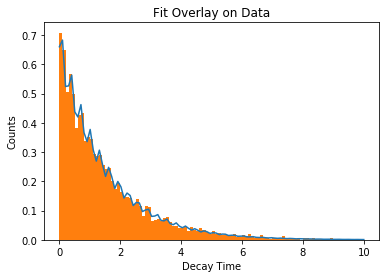

Param Values for low_s datapoints::
Tau: 1.584 +/- 0.024
V: 0.117 +/- 0.020
Delta M: 20.008 +/- 0.078




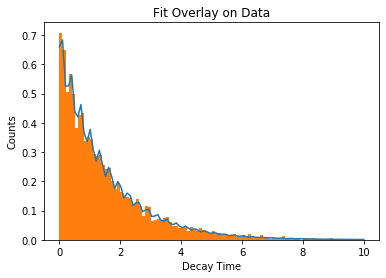

Param Values for high_s datapoints::
Tau: 1.445 +/- 0.020
V: 0.117 +/- 0.020
Delta M: 20.008 +/- 0.078




In [11]:
OG_data = allData[0]
accParams = []
accErrors = []
avgParams = []
avgErrors = []

for i in ['low_s', 'high_s']:
    if i == 'low_s':
        pdf_class = low_s
    else:
        pdf_class = high_s
        
    minParams = {'tau':1.5, 'v':0.1, 'm':20.0, 'error_tau':0.1, 'error_v':0.1, 'error_m':0.1}
    listParams = [1.5, 0.1, 20.0]
    outParams, outErrors = fit(pdf_class, OG_data, minParams, listParams, evalPDF, plot = True, analytic = True)
    accParams.append(outParams)
    accErrors.append(outErrors)
    
    print('Param Values for {} datapoints::'.format(i))
    print('Tau: {:.3f} +/- {:.3f}'.format(outParams[0], outErrors[0]))
    print('V: {:.3f} +/- {:.3f}'.format(outParams[1], outErrors[1]))
    print('Delta M: {:.3f} +/- {:.3f}'.format(outParams[2], outErrors[2]))
    print('\n')

In [12]:
#finds the average differnce in params for the two modified pdfs
avgShifts = []
for i in range(len(accParams[0])):
    low = abs(allParams[0][i] - accParams[0][i])
    high = abs(allParams[0][i] - accParams[1][i])
    avgShifts.append((low + high)/2)
    
print('Systematic errors: ')
print('Tau: {:.4f}'.format(avgShifts[0]))
print('V: {:.4f}'.format(avgShifts[1]))
print('Delta M: {:.4f} '.format(avgShifts[2]))
print('\n')

print('Statistical Errors: ')
print('Tau: +/- {:.4f}'.format(allErrors[0][0]))
print('V:  +/- {:.4f}'.format(allErrors[0][1]))
print('Delta M:  +/- {:.4f}'.format(allErrors[0][2]))
print('\n')

Systematic errors: 
Tau: 0.0695
V: 0.0001
Delta M: 0.0001 


Statistical Errors: 
Tau: +/- 0.0213
V:  +/- 0.0200
Delta M:  +/- 0.0783




Comparing the systematic errors calculated using the acceptance time change to the original statistical errors calculation we see:
 - The systematic error for the lifetime is quite large in comparison to that of the statistical error.
 - Both the v and delta m parameters systematic errors are smaller than their statistical errors.
 - This means that the systematic error on tau is more impotrant whereas it may be said that the systematics on the other two params are less so.